In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer
import sys
sys.path.append('icd9')
from icd9 import ICD9
import re
import pickle
import seaborn as sns
import pylab
from scipy.cluster.hierarchy import dendrogram, linkage
sns.set()

In [2]:
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

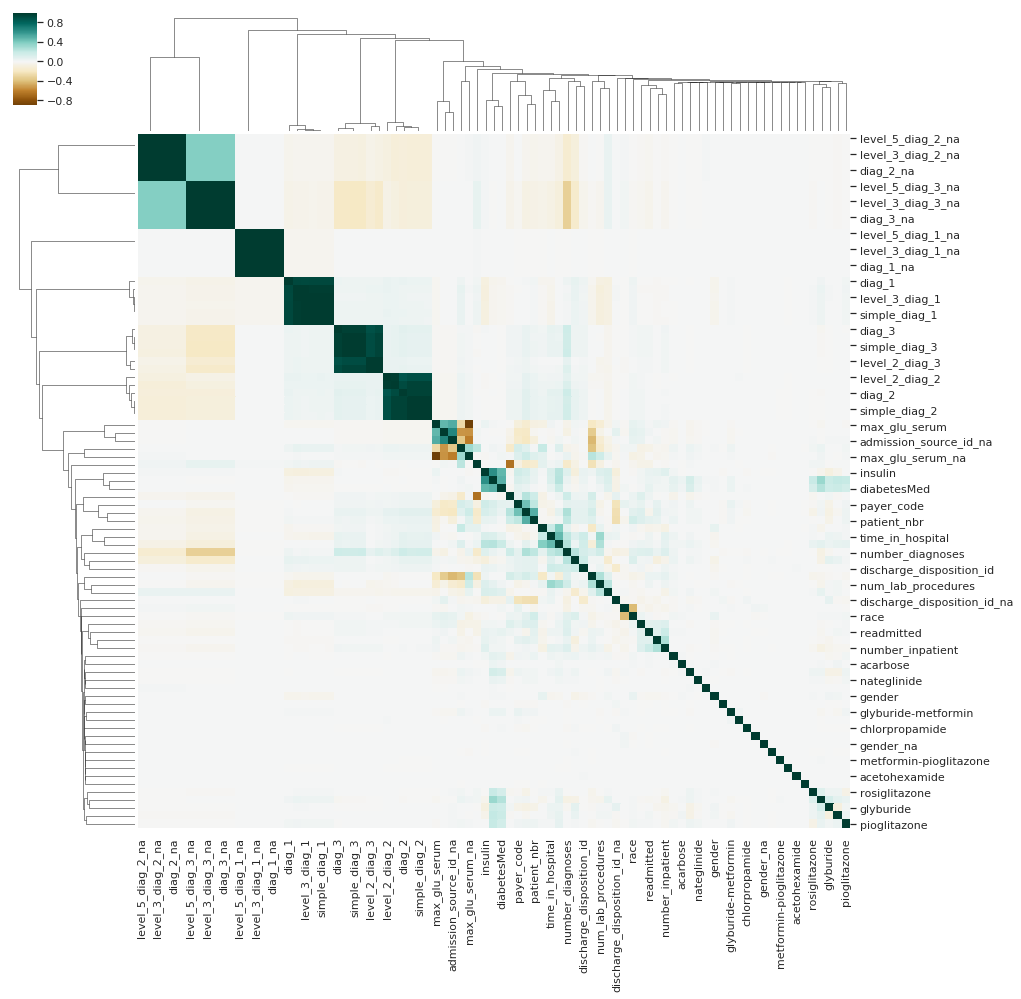

In [3]:
corr = df.corr()
sns.clustermap(corr,
        center=0,
        cmap='BrBG',
        figsize=(15, 15))

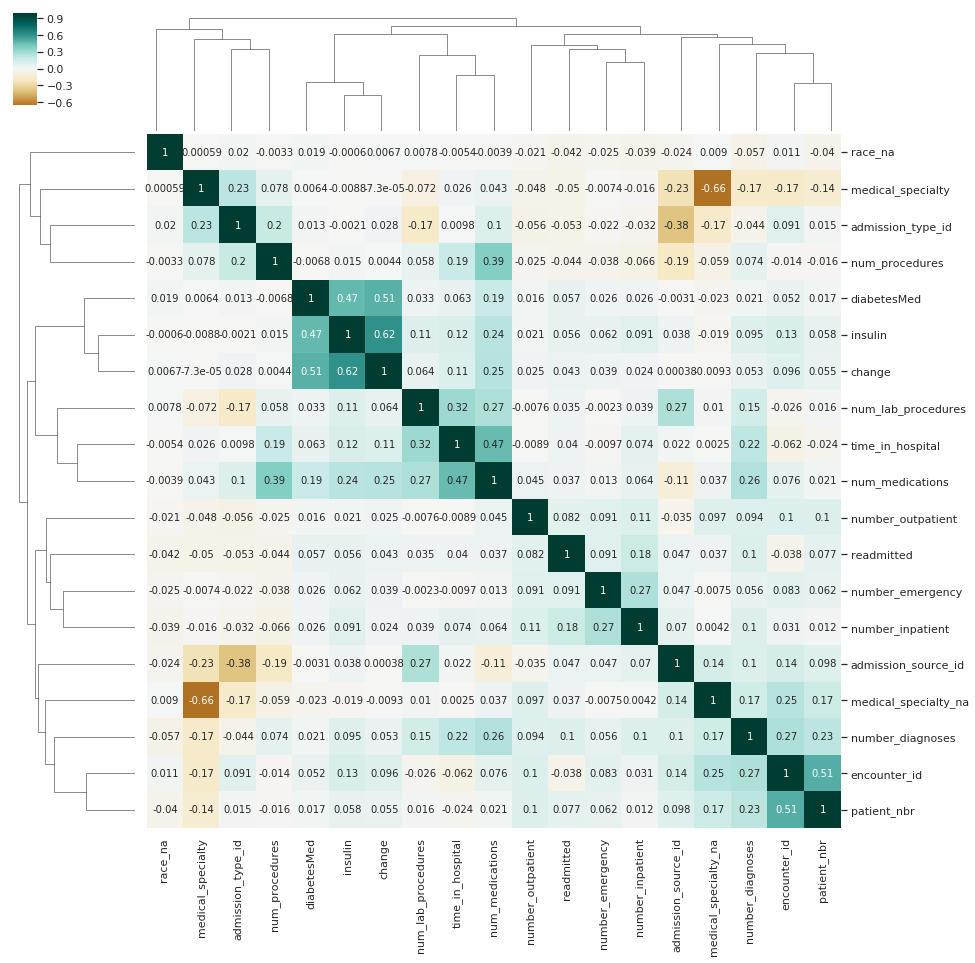

In [4]:
corr_thresh = 0.035
df_correlated = df.loc[:, ((corr.readmitted.sort_values()<-corr_thresh) | (corr.readmitted.sort_values()>corr_thresh))]
corr_high = df_correlated.corr()
p = sns.clustermap(corr_high,
        square=True,
        center=0,
        cmap='BrBG',
        annot=True,
        figsize=(15, 15))

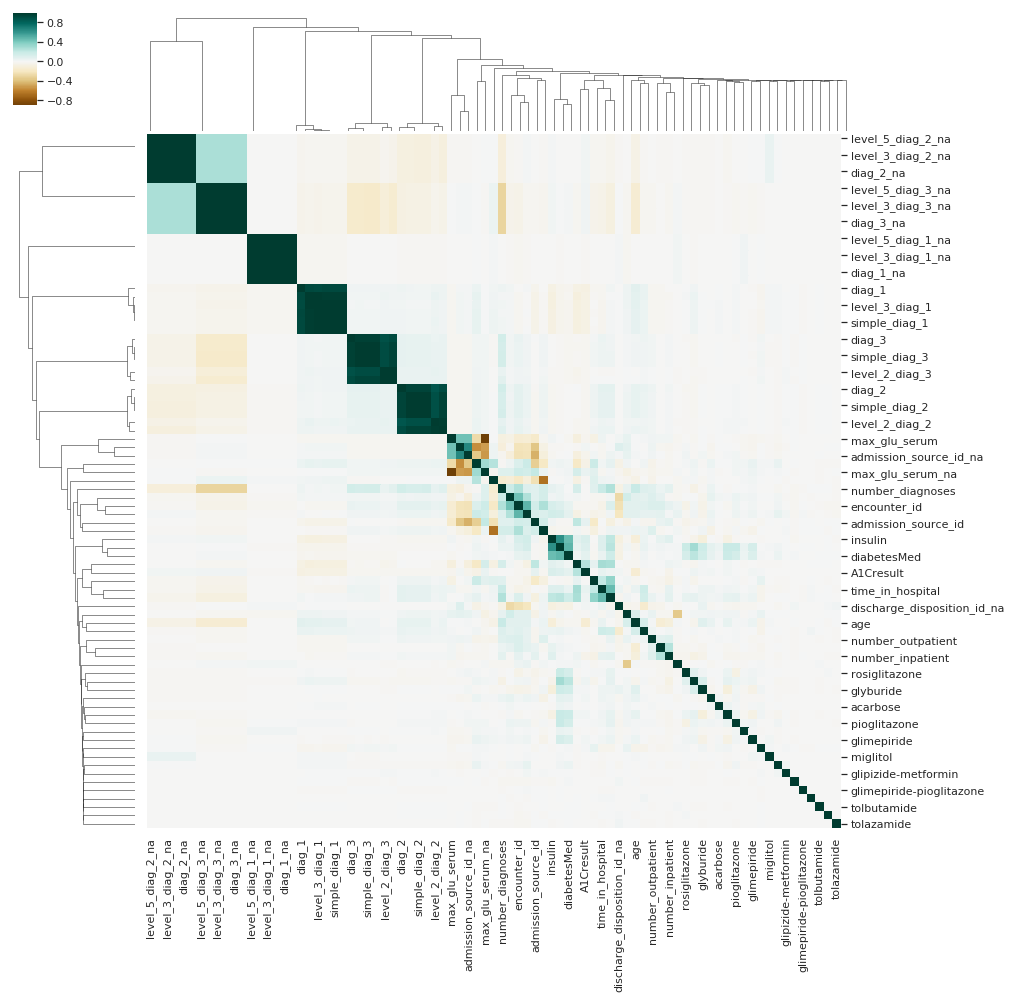

In [35]:
df_less30 = df.loc[df.readmitted == 2, :].copy()
del df_less30['readmitted']

corr_less30 = df_less30.corr()
corr_less30 = corr_less30.dropna(axis=0, how='all')
corr_less30 = corr_less30.dropna(axis=1, how='all')
corr_less30
p = sns.clustermap(corr_less30,
        square=True,
        center=0,
        cmap='BrBG',
        #annot=True,
        figsize=(15, 15))

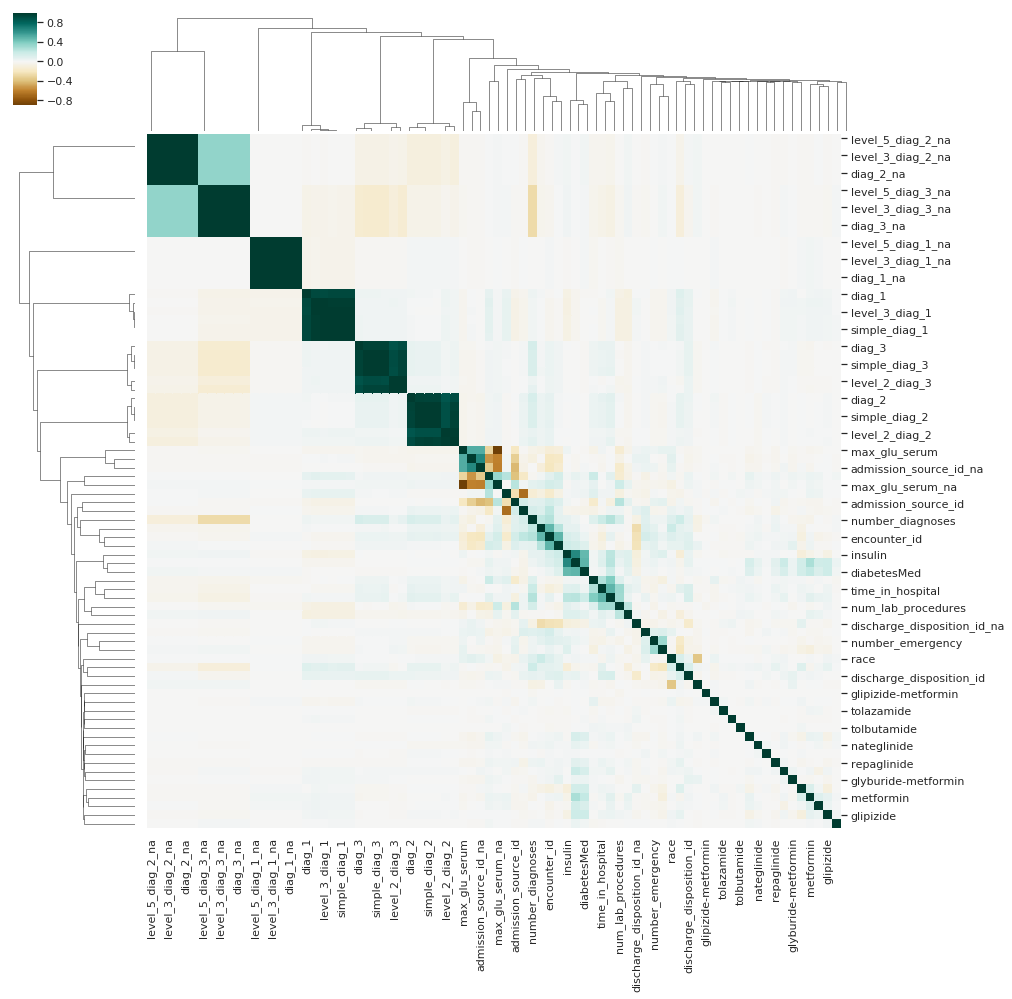

In [36]:
df_more30 = df.loc[df.readmitted == 1, :].copy()
del df_more30['readmitted']

corr_more30 = df_more30.corr()
corr_more30 = corr_more30.dropna(axis=0, how='all')
corr_more30 = corr_more30.dropna(axis=1, how='all')
corr_more30
p = sns.clustermap(corr_more30,
        square=True,
        center=0,
        cmap='BrBG',
        #annot=True,
        figsize=(15, 15))

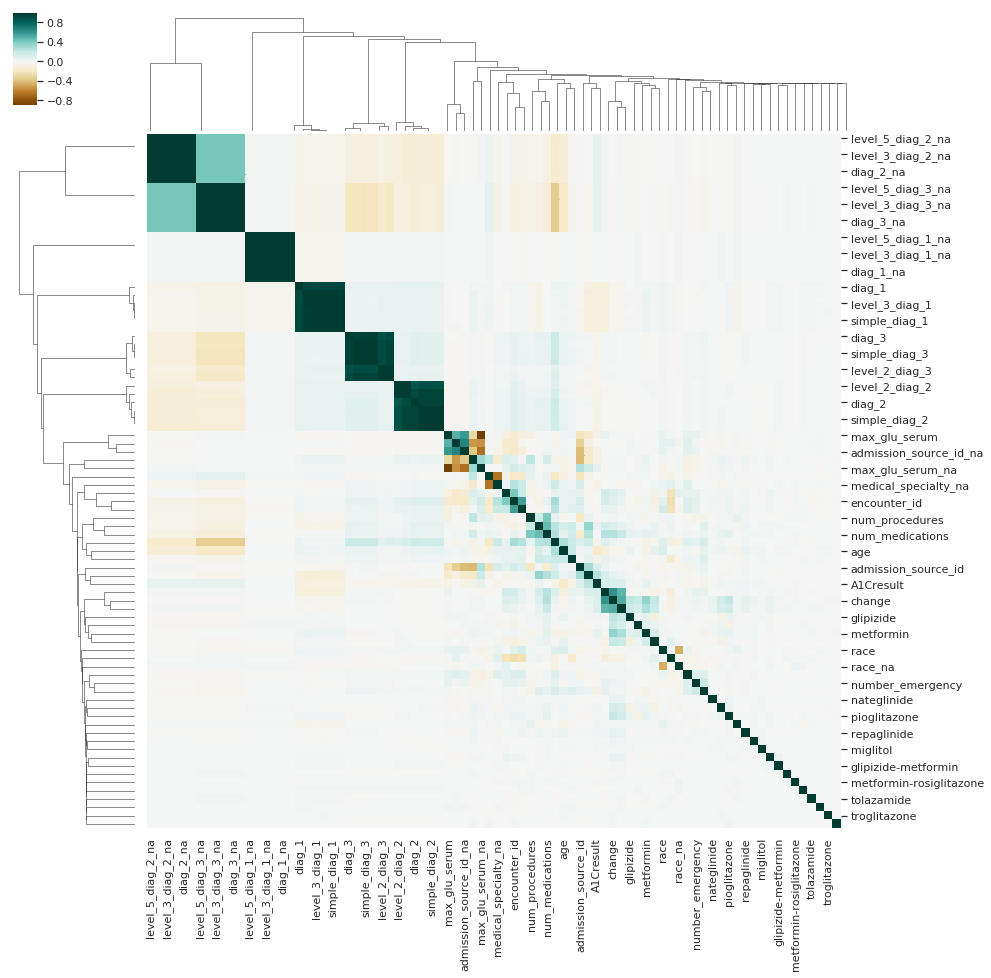

In [37]:
df_noreadm = df.loc[df.readmitted == 0, :].copy()
del df_noreadm['readmitted']

corr_noreadm = df_noreadm.corr()
corr_noreadm = corr_noreadm.dropna(axis=0, how='all')
corr_noreadm = corr_noreadm.dropna(axis=1, how='all')
corr_noreadm
p = sns.clustermap(corr_noreadm,
        square=True,
        center=0,
        cmap='BrBG',
        #annot=True,
        figsize=(15, 15))

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Observed Pearson correlation coefficient: 0.4635089552918075
p-val = 0.0003


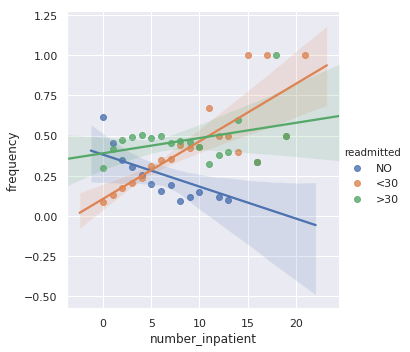

In [5]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglit', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
def frequencies_by_groups(df, groups, df_labels):
    by_groups = df[groups].groupby(groups).size()
    by_groups.name = 'value_count'
    by_groups = by_groups.reset_index()
    by_group1_sum = df[groups].groupby(groups[0]).size()
    by_group1_sum.name = 'sum_by_{}'.format(groups[0])
    by_group1_sum = by_group1_sum.reset_index()
    by_groups_merged = by_groups.merge(by_group1_sum)
    by_groups_merged['frequency'] = by_groups_merged.value_count.divide(by_groups_merged['sum_by_{}'.format(groups[0])])
    by_groups_merged.readmitted = by_groups_merged.readmitted.map(dict(zip(range(len(df_labels['readmitted'])), df_labels['readmitted'])))
    if groups[0] in drugs:
        by_groups_merged[groups[0]] = by_groups_merged[groups[0]].map(dict(zip(range(len(df_labels['drugs'])), df_labels['drugs'])))
    elif groups[0] in df_labels.keys():
        by_groups_merged[groups[0]] = by_groups_merged[groups[0]].map(dict(zip(range(len(df_labels[groups[0]])), df_labels[groups[0]])))
    return by_groups_merged
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

def test_pearson(x, y, n):
    # Compute observed correlation: r_obs
    r_obs = pearson_r(x, y)
    print('Observed Pearson correlation coefficient: {}'.format(r_obs))

    # Initialize permutation replicates: perm_replicates
    perm_replicates = np.empty(n)

    np.random.seed(342)
    # Draw replicates
    for i in range(n):
        # Permute illiteracy measurments: illiteracy_permuted
        x_permutated = np.random.permutation(x)

        # Compute Pearson correlation
        perm_replicates[i] = pearson_r(x_permutated, y)

    # Compute p-value: p
    p = np.sum((perm_replicates <= -abs(r_obs)) | (perm_replicates >= abs(r_obs))) / n
    print('p-val =', p)
by_number_inpatient = frequencies_by_groups(df, ['number_inpatient', 'readmitted'], df_labels)
sns.lmplot(x='number_inpatient', y='frequency', hue='readmitted', data=by_number_inpatient)
test_pearson(by_number_inpatient.number_inpatient.values, by_number_inpatient.frequency.values, 10000)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Observed Pearson correlation coefficient: 0.7114264380377502
p-val = 0.0


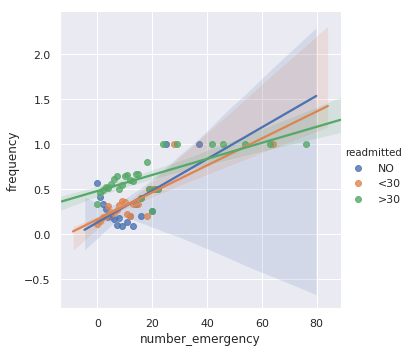

In [6]:
by_number_emergency = frequencies_by_groups(df, ['number_emergency', 'readmitted'], df_labels)
sns.lmplot(x='number_emergency', y='frequency', hue='readmitted', data=by_number_emergency)
test_pearson(by_number_emergency.number_emergency.values, by_number_emergency.frequency.values, 10000)

/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Observed Pearson correlation coefficient: 0.6383096531021925
p-val = 0.0


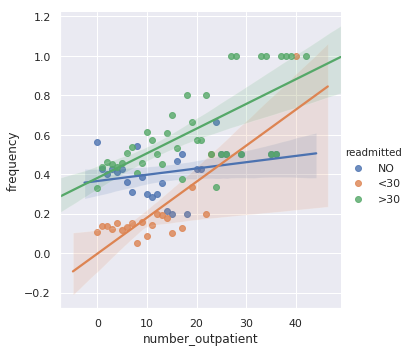

In [7]:
by_number_outpatient = frequencies_by_groups(df, ['number_outpatient', 'readmitted'], df_labels)
sns.lmplot(x='number_outpatient', y='frequency', hue='readmitted', data=by_number_outpatient)
test_pearson(by_number_outpatient.number_outpatient.values, by_number_outpatient.frequency.values, 10000)